**Load the Emotion-Labeled Dataset**

In [1]:
import os
import librosa
import numpy as np

# Path to dataset
DATA_PATH = "C:/Users/darsh/OneDrive/Desktop/Project/__pycache__/Audio_Speech_Actors_01-24"

# Load an example file
file_path = os.path.join(DATA_PATH, "C:/Users/darsh/OneDrive/Desktop/Project/__pycache__/Audio_Speech_Actors_01-24/Actor_01/03-01-01-01-01-01-01.wav")  # Update with actual file
signal, sr = librosa.load(file_path, sr=22050)  # 22.05 kHz is standard for speech
print(f"Audio duration: {librosa.get_duration(y=signal, sr=sr)} seconds")

Audio duration: 3.3033106575963718 seconds


In [26]:
import os
import numpy as np
from sklearn.model_selection import train_test_split

features = []
labels = []

# Recursively walk through DATA_PATH to find all .wav files
for root, dirs, files in os.walk(DATA_PATH):
    for file_name in files:
        if file_name.endswith(".wav"):
            # Extract emotion label from filename (assuming format with '-' separators)
            emotion_label = file_name.split("-")[2]
            file_path = os.path.join(root, file_name)
            mfcc = extract_features(file_path)
            features.append(mfcc)
            labels.append(emotion_label)

# Convert to numpy arrays
X = np.array(features)
y = np.array(labels)

# Split the data with stratification to maintain label distribution
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)


**Visualize Raw Waveform**

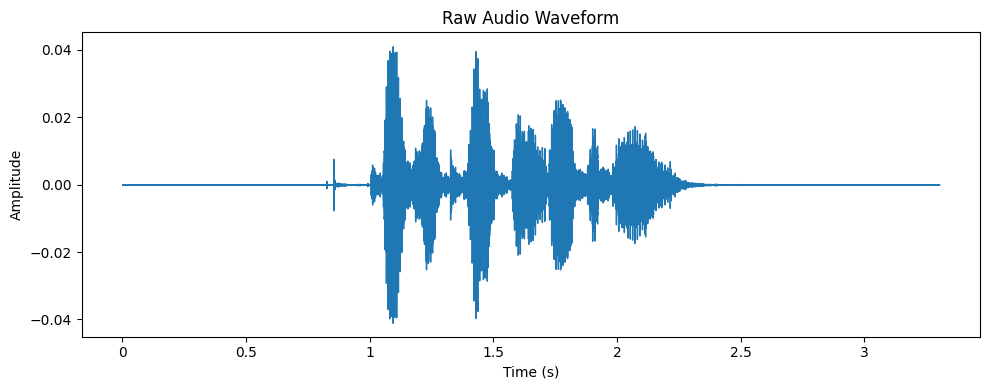

In [20]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 4))
librosa.display.waveshow(signal, sr=sr)
plt.title("Raw Audio Waveform")
plt.xlabel("Time (s)")
plt.ylabel("Amplitude")
plt.tight_layout()
plt.show()

**Compute MFCCs from Audio**

In [21]:
# Extract MFCC features
mfccs = librosa.feature.mfcc(y=signal, sr=sr, n_mfcc=13)

# Print shape: (13 coefficients × time frames)
print("MFCCs shape:", mfccs.shape)

MFCCs shape: (13, 143)


**Visualize MFCCs**

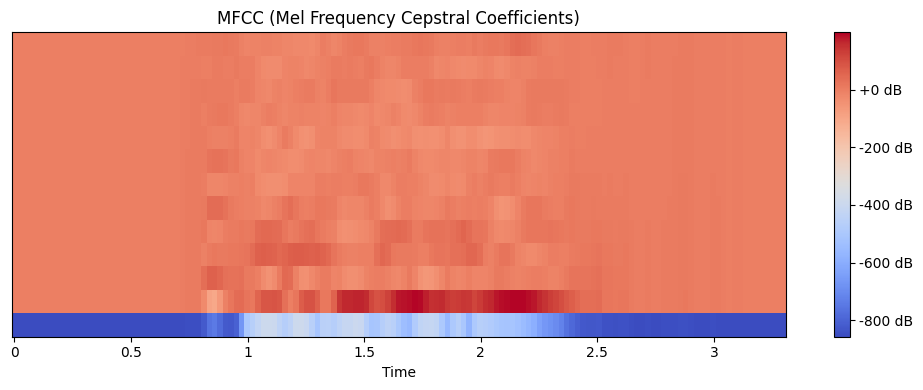

In [22]:
import librosa.display

plt.figure(figsize=(10, 4))
librosa.display.specshow(mfccs, x_axis='time', sr=sr)
plt.colorbar(format='%+2.0f dB')
plt.title("MFCC (Mel Frequency Cepstral Coefficients)")
plt.tight_layout()
plt.show()

**End-to-End Function for Preprocessing**

In [23]:
def extract_features(file_path, n_mfcc=13):
    signal, sr = librosa.load(file_path, sr=22050)
    mfccs = librosa.feature.mfcc(y=signal, sr=sr, n_mfcc=n_mfcc)
    mfccs_processed = np.mean(mfccs.T, axis=0)  # Mean pooling
    return mfccs_processed

**Batch Processing for Dataset Preparation**

In [24]:
features = []
labels = []

for file_name in os.listdir(DATA_PATH):
    if file_name.endswith(".wav"):
        emotion_label = file_name.split("-")[2]  # Example: extract from file naming convention
        file_path = os.path.join(DATA_PATH, file_name)
        mfcc = extract_features(file_path)
        features.append(mfcc)
        labels.append(emotion_label)

# Convert to numpy arrays
X = np.array(features)
y = np.array(labels)

**Building the Emotion Classifier**

*Step 1: Split the Data*

In [27]:
from sklearn.model_selection import train_test_split

# X = list of MFCC feature arrays
# y = corresponding emotion labels
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

*Step 2: Choose the Right Models*

In [28]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

# Initialize models
rf_model = RandomForestClassifier(random_state=42)
svm_model = SVC(kernel='rbf', probability=True, random_state=42)

*Step 3: Tune and Validate with Cross-Validation*

In [29]:
from sklearn.model_selection import GridSearchCV, StratifiedKFold

# Define hyperparameter grids
rf_params = {
    'n_estimators': [100, 200],
    'max_depth': [None, 10, 20]
}

svm_params = {
    'C': [1, 10, 100],
    'gamma': ['scale', 0.01, 0.1]
}

# 10-fold cross-validation
cv = StratifiedKFold(n_splits=10)

# Grid Search
rf_grid = GridSearchCV(rf_model, rf_params, cv=cv, scoring='accuracy', n_jobs=-1)
svm_grid = GridSearchCV(svm_model, svm_params, cv=cv, scoring='accuracy', n_jobs=-1)

# Fit models
rf_grid.fit(X_train, y_train)
svm_grid.fit(X_train, y_train)

,estimator,SVC(probabili...ndom_state=42)
,param_grid,"{'C': [1, 10, ...], 'gamma': ['scale', 0.01, ...]}"
,scoring,'accuracy'
,n_jobs,-1
,refit,True
,cv,StratifiedKFo...shuffle=False)
,verbose,0
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,C,10


*Step 4: Evaluate the Model*

Random Forest Accuracy: 0.5763888888888888
SVM Accuracy: 0.4479166666666667


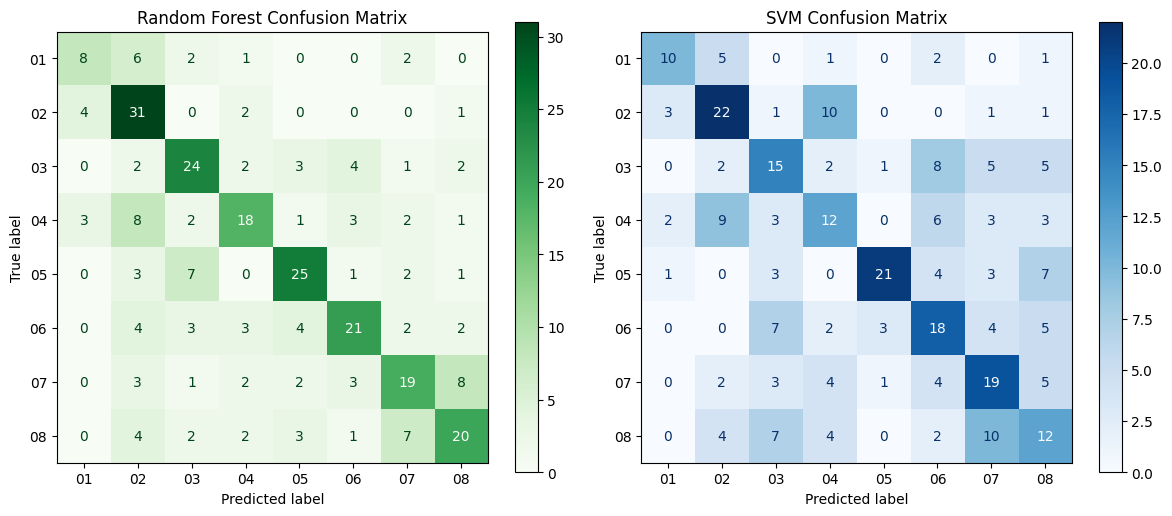

In [30]:
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Best estimators from grid search
best_rf = rf_grid.best_estimator_
best_svm = svm_grid.best_estimator_

# Predictions
rf_preds = best_rf.predict(X_test)
svm_preds = best_svm.predict(X_test)

# Accuracy scores
rf_acc = accuracy_score(y_test, rf_preds)
svm_acc = accuracy_score(y_test, svm_preds)

print("Random Forest Accuracy:", rf_acc)
print("SVM Accuracy:", svm_acc)

# Confusion Matrices
fig, axes = plt.subplots(1, 2, figsize=(12, 5))
ConfusionMatrixDisplay(confusion_matrix(y_test, rf_preds), display_labels=best_rf.classes_).plot(ax=axes[0], cmap="Greens")
axes[0].set_title("Random Forest Confusion Matrix")

ConfusionMatrixDisplay(confusion_matrix(y_test, svm_preds), display_labels=best_svm.classes_).plot(ax=axes[1], cmap="Blues")
axes[1].set_title("SVM Confusion Matrix")
plt.tight_layout()
plt.show()

In [31]:
import joblib

# After grid search and fitting:
joblib.dump(rf_grid.best_estimator_, "model.pkl")

['model.pkl']

**Confusion Matrix & Classification Report**

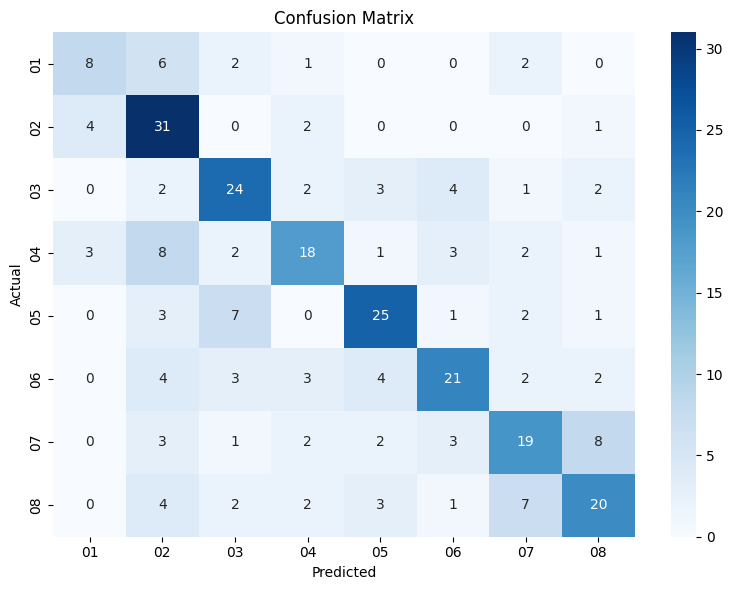

In [33]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt
import joblib

model = joblib.load("model.pkl")

#y_true: true labels
y_pred = model.predict(X_test)

def plot_confusion_matrix(y_true, y_pred, labels):
    labels = sorted(list(set(y_true) | set(y_pred)))
    cm = confusion_matrix(y_true, y_pred, labels=labels)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=labels, yticklabels=labels)
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title("Confusion Matrix")
    plt.tight_layout()
    plt.show()

# Example usage:
labels = ['angry', 'calm', 'happy', 'sad']
plot_confusion_matrix(y_test, y_pred, labels=labels)

**Per-Class Accuracy Bar Chart**

C:\Users\darsh\AppData\Roaming\Python\Python312\site-packages\numpy\lib\function_base.py:520: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
C:\Users\darsh\AppData\Roaming\Python\Python312\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
C:\Users\darsh\AppData\Roaming\Python\Python312\site-packages\numpy\lib\function_base.py:520: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
C:\Users\darsh\AppData\Roaming\Python\Python312\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
C:\Users\darsh\AppData\Roaming\Python\Python312\site-packages\numpy\lib\function_base.py:520: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
C:\Users\darsh\AppData\Roaming\Python\Python312\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encount

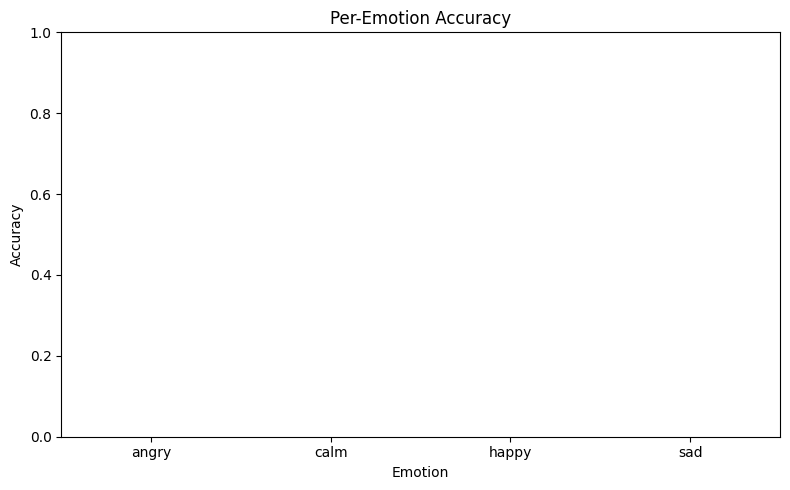

In [34]:
import pandas as pd

def plot_per_class_accuracy(y_true, y_pred, labels):
    from sklearn.metrics import accuracy_score
    accuracies = {}
    for label in labels:
        indices = [i for i, y in enumerate(y_true) if y == label]
        sub_y_true = [y_true[i] for i in indices]
        sub_y_pred = [y_pred[i] for i in indices]
        accuracies[label] = accuracy_score(sub_y_true, sub_y_pred)

    # Convert to DataFrame
    df = pd.DataFrame(list(accuracies.items()), columns=['Emotion', 'Accuracy'])

    # Plot
    df.plot(kind='bar', x='Emotion', y='Accuracy', legend=False, color='skyblue', figsize=(8, 5))
    plt.ylim(0, 1)
    plt.title('Per-Emotion Accuracy')
    plt.ylabel('Accuracy')
    plt.xticks(rotation=0)
    plt.tight_layout()
    plt.show()

plot_per_class_accuracy(y_test, y_pred, labels)

**Hyperparameter Tuning: Random Forest**

In [35]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

param_grid = {
    'n_estimators': [50, 100, 150],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5, 10]
}

grid = GridSearchCV(
    estimator=RandomForestClassifier(random_state=42),
    param_grid=param_grid,
    cv=5,
    n_jobs=-1,
    scoring='accuracy'
)

grid.fit(X_train, y_train)

print("Best Parameters:", grid.best_params_)
print("Best Score:", grid.best_score_)

Best Parameters: {'max_depth': None, 'min_samples_split': 2, 'n_estimators': 150}
Best Score: 0.5451270468661773


**Hyperparameter Tuning: SVM with RBF Kernel**

In [36]:
from sklearn.svm import SVC

param_grid = {
    'C': [0.1, 1, 10],
    'gamma': ['scale', 0.01, 0.001],
    'kernel': ['rbf']
}

grid = GridSearchCV(SVC(), param_grid, cv=5, scoring='accuracy', n_jobs=-1)
grid.fit(X_train, y_train)

print("Best SVM Parameters:", grid.best_params_)
print("Best SVM Score:", grid.best_score_)

Best SVM Parameters: {'C': 10, 'gamma': 0.001, 'kernel': 'rbf'}
Best SVM Score: 0.49480519480519475
